In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import ast
from datetime import datetime

%matplotlib inline

<IPython.core.display.Javascript object>

# Read dataframes, drop duplicate genres

In [3]:
hot_100 = pd.read_csv("data/Hot_Stuff.csv")
spotify = pd.read_excel("data/Hot_100_Audio_Features.xlsx")

<IPython.core.display.Javascript object>

In [4]:
spotify["spotify_genre"].explode().value_counts()

[]                                                                            2541
['contemporary country', 'country', 'country road']                            315
['contemporary country', 'country', 'country road', 'modern country rock']     279
['dance pop', 'pop', 'post-teen pop']                                          252
['glee club', 'hollywood', 'post-teen pop']                                    205
                                                                              ... 
['bakersfield sound', 'oklahoma country']                                        1
['boston rock', 'jangle pop']                                                    1
['bronx hip hop', 'hip pop', 'r&b', 'trap queen']                                1
['bluegrass', 'folk', 'progressive bluegrass']                                   1
['acoustic pop', 'ann arbor indie']                                              1
Name: spotify_genre, Length: 3275, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
spotify = spotify.drop_duplicates()

<IPython.core.display.Javascript object>

# Drop columns that are not needed

In [6]:
hot_100 = hot_100.drop(columns=["url"])

<IPython.core.display.Javascript object>

In [7]:
spotify = spotify.drop(
    columns=[
        "spotify_track_id",
        "spotify_track_preview_url",
        "spotify_track_duration_ms",
        "spotify_track_popularity",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "acousticness",
        "speechiness",
        "liveness",
        "instrumentalness",
        "valence",
        "tempo",
        "time_signature",
    ]
)

<IPython.core.display.Javascript object>

# Basic table description data

In [8]:
hot_100.shape

(320495, 9)

<IPython.core.display.Javascript object>

In [9]:
hot_100.isna().sum()

WeekID                        0
Week Position                 0
Song                          0
Performer                     0
SongID                        0
Instance                      0
Previous Week Position    30784
Peak Position                 0
Weeks on Chart                0
dtype: int64

<IPython.core.display.Javascript object>

In [10]:
hot_100.head()

,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


<IPython.core.display.Javascript object>

In [11]:
hot_100.dtypes

WeekID                     object
Week Position               int64
Song                       object
Performer                  object
SongID                     object
Instance                    int64
Previous Week Position    float64
Peak Position               int64
Weeks on Chart              int64
dtype: object

<IPython.core.display.Javascript object>

In [12]:
spotify.shape

(28470, 6)

<IPython.core.display.Javascript object>

In [13]:
spotify.isna().mean()

SongID                    0.000000
Performer                 0.000000
Song                      0.000000
spotify_genre             0.043133
spotify_track_album       0.166737
spotify_track_explicit    0.166526
dtype: float64

<IPython.core.display.Javascript object>

In [14]:
spotify.head()

,SongID,Performer,Song,spotify_genre,spotify_track_album,spotify_track_explicit
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],Adicto (with Anuel AA & Ozuna),0.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",A Star Is Born Soundtrack,0.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",Hollywood's Bleeding,1.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",Bacc At It Again,1.0


<IPython.core.display.Javascript object>

In [15]:
spotify.dtypes

SongID                     object
Performer                  object
Song                       object
spotify_genre              object
spotify_track_album        object
spotify_track_explicit    float64
dtype: object

<IPython.core.display.Javascript object>

# Fill null values, convert floats to int

In [16]:
spotify["spotify_track_album"].fillna(" ", inplace=True)
hot_100["Previous Week Position"].fillna(int(0), inplace=True)

<IPython.core.display.Javascript object>

In [17]:
hot_100 = hot_100.astype({"Previous Week Position": int})

<IPython.core.display.Javascript object>

In [18]:
spotify["spotify_genre"].fillna("[]", inplace=True)
spotify["spotify_genre_list"] = spotify["spotify_genre"].apply(ast.literal_eval)

<IPython.core.display.Javascript object>

# Join the 2 tables by SongID (song and performer)

In [19]:
full_table = hot_100.merge(spotify, left_on="SongID", right_on="SongID")
full_table

,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Performer_y,Song_y,spotify_genre,spotify_track_album,spotify_track_explicit,spotify_genre_list
0,2/2/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,0,1,1,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
1,5/25/2019,11,7 Rings,Ariana Grande,7 RingsAriana Grande,1,10,1,17,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
2,4/20/2019,4,7 Rings,Ariana Grande,7 RingsAriana Grande,1,3,1,12,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
3,6/1/2019,12,7 Rings,Ariana Grande,7 RingsAriana Grande,1,11,1,18,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
4,3/30/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,1,1,9,Ariana Grande,7 Rings,"['dance pop', 'pop', 'post-teen pop']",thank,1.0,"[dance pop, pop, post-teen pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320602,8/25/1962,18,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,23,18,7,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320603,9/1/1962,12,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,18,12,8,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320604,9/8/1962,14,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,12,12,9,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"
320605,9/15/1962,31,What's A Matter Baby (Is It Hurting You),Timi Yuro,What's A Matter Baby (Is It Hurting You)Timi Yuro,1,14,12,10,Timi Yuro,What's A Matter Baby (Is It Hurting You),"['adult standards', 'brill building pop']",The Best Of Timi Yuro,0.0,"[adult standards, brill building pop]"


<IPython.core.display.Javascript object>

# Remove unnecessary columns, re-label columns

In [20]:
full_table = full_table.drop(columns=["Performer_y", "Song_y"])

<IPython.core.display.Javascript object>

In [21]:
full_table.rename(
    columns={
        "WeekID": "week",
        "Week Position": "week_pos",
        "Song_x": "song",
        "Performer_x": "artist",
        "SongID": "song_id",
        "Instance": "instance",
        "Previous Week Position": "prev_week_pos",
        "Peak Position": "peak_pos",
        "Weeks on Chart": "weeks_on_chart",
        "spotify_genre": "genre_str",
        "spotify_genre_list": "genre_list",
        "spotify_track_album": "album",
        "spotify_track_explicit": "explicit",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

# Format week to a date format

In [22]:
full_table["week"] = full_table["week"].apply(
    lambda x: datetime.strptime(x, "%m/%d/%Y")
)
full_table["week"] = pd.to_datetime(full_table["week"])

<IPython.core.display.Javascript object>

# Put month and year in new columns

In [23]:
full_table["year"], full_table["month"] = (
    full_table["week"].dt.year,
    full_table["week"].dt.month,
)

<IPython.core.display.Javascript object>

# Check explicit vs not explicit

In [24]:
full_table["explicit"].value_counts()

0.0    249361
1.0     31060
Name: explicit, dtype: int64

<IPython.core.display.Javascript object>

# Create a table with means, only use songs in the top 50 to make the dataframe a little smaller.  This is the main table used in analysis.

In [25]:
top_song_limit = 50
top_songs = full_table[full_table["week_pos"] <= top_song_limit]
top_songs = top_songs.groupby(["song_id", "genre_str"]).mean()
top_songs = top_songs.reset_index()
top_songs

,song_id,genre_str,week_pos,instance,prev_week_pos,peak_pos,weeks_on_chart,explicit,year,month
0,"""Cherry Cherry"" from Hot August NightNeil Diamond","['adult standards', 'brill building pop', 'fol...",37.333333,1.0,41.500000,37.333333,6.5,0.0,1973.000000,4.333333
1,"""Joy"" Pt. IIsaac Hayes","['classic soul', 'disco', 'funk', 'jazz funk',...",35.142857,1.0,38.000000,33.428571,6.0,NaN,1974.000000,1.428571
2,"""Yep!""Duane Eddy His Twangy Guitar And The Rebels",[],40.500000,1.0,44.250000,34.000000,4.5,NaN,1959.000000,4.250000
3,#1Nelly,"['dance pop', 'hip hop', 'pop', 'pop rap', 'ra...",27.384615,1.0,28.384615,24.153846,11.0,1.0,2001.461538,6.923077
4,#9 DreamJohn Lennon,"['album rock', 'classic rock', 'folk rock', 'm...",24.100000,1.0,25.200000,19.900000,7.5,0.0,1975.000000,1.800000
...,...,...,...,...,...,...,...,...,...,...
15282,iSpyKYLE Featuring Lil Yachty,"['pop rap', 'rap']",19.857143,1.0,20.428571,11.214286,16.5,1.0,2017.000000,4.571429
15283,teachmeMusiq Soulchild,"['alternative r&b', 'dance pop', 'neo soul', '...",46.333333,1.0,48.000000,44.666667,13.0,0.0,2007.000000,8.000000
15284,whoa (mind in awe)XXXTENTACION,"['emo rap', 'miami hip hop']",37.000000,1.0,0.000000,37.000000,1.0,0.0,2018.000000,12.000000
15285,www.memoryAlan Jackson,"['contemporary country', 'country', 'country r...",48.000000,1.0,49.000000,47.200000,7.0,NaN,2000.000000,12.000000


<IPython.core.display.Javascript object>

# Add a genre label column.  Evaluate all of the genres in the list, and make a single genre decision.

In [26]:
genre_list = ["rap", "hip hop", "metal", "country", "pop"]

<IPython.core.display.Javascript object>

In [27]:
for genre in genre_list:
    top_songs[genre] = top_songs["genre_str"].str.contains(fr"\b{genre}\b")

<IPython.core.display.Javascript object>

In [28]:
top_songs.loc[top_songs["pop"], "genre_label"] = "pop"
top_songs.loc[top_songs["rap"] | top_songs["hip hop"], "genre_label"] = "rap_hiphop"
top_songs.loc[top_songs["metal"], "genre_label"] = "metal"
top_songs.loc[top_songs["country"], "genre_label"] = "country"

top_songs["genre_label"].value_counts()

pop           5421
rap_hiphop    1962
country       1705
metal          423
Name: genre_label, dtype: int64

<IPython.core.display.Javascript object>

# Split the top songs by genre and make violin plots

In [29]:
pop = top_songs[top_songs["genre_label"] == "pop"]
rap_hiphop = top_songs[top_songs["genre_label"] == "rap_hiphop"]
country = top_songs[top_songs["genre_label"] == "country"]
metal = top_songs[top_songs["genre_label"] == "metal"]

<IPython.core.display.Javascript object>

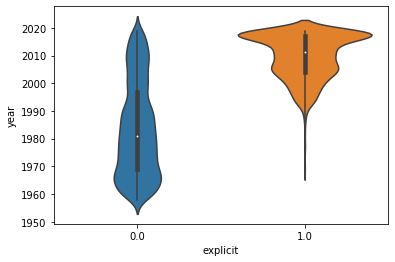

<IPython.core.display.Javascript object>

In [30]:
sns.violinplot(x="explicit", y="year", data=top_songs)
plt.show()

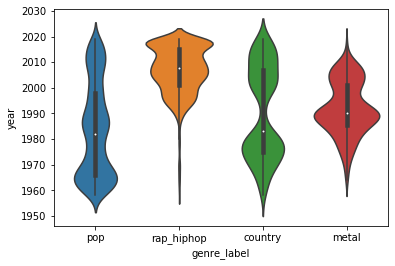

<IPython.core.display.Javascript object>

In [31]:
sns.violinplot(x="genre_label", y="year", data=top_songs)
plt.show()

## ANOVA Assumption Check - Popularity.  
### The week position is the mean of all the weekly Hot 100 positions of each song.

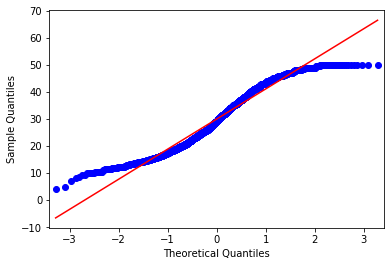

<IPython.core.display.Javascript object>

In [32]:
qqplot(rap_hiphop["week_pos"], line="s")
plt.show()

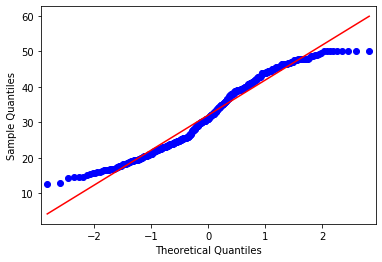

<IPython.core.display.Javascript object>

In [33]:
qqplot(metal["week_pos"], line="s")
plt.show()

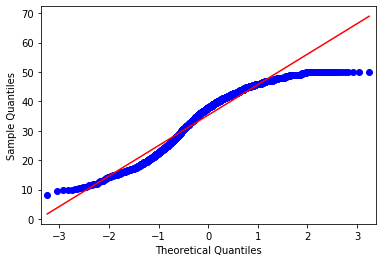

<IPython.core.display.Javascript object>

In [34]:
qqplot(country["week_pos"], line="s")
plt.show()

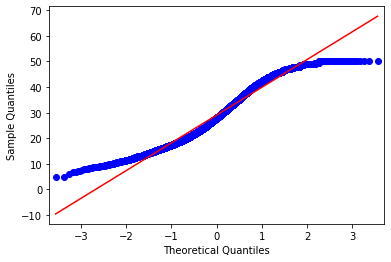

<IPython.core.display.Javascript object>

In [35]:
qqplot(pop["week_pos"], line="s")
plt.show()

## Kruskal Wallis - Popularity

[]

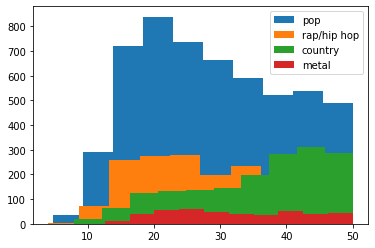

<IPython.core.display.Javascript object>

In [36]:
plt.hist(pop["week_pos"], label="pop")
plt.hist(rap_hiphop["week_pos"], label="rap/hip hop")
plt.hist(country["week_pos"], label="country")
plt.hist(metal["week_pos"], label="metal")
plt.legend()
plt.plot()

In [37]:
_, p = stats.kruskal(
    pop["week_pos"], rap_hiphop["week_pos"], country["week_pos"], metal["week_pos"]
)
p

6.913449305087655e-93

<IPython.core.display.Javascript object>

In [38]:
_, p1 = stats.mannwhitneyu(pop["week_pos"], rap_hiphop["week_pos"])
_, p2 = stats.mannwhitneyu(pop["week_pos"], country["week_pos"])
_, p3 = stats.mannwhitneyu(pop["week_pos"], metal["week_pos"])
_, p4 = stats.mannwhitneyu(rap_hiphop["week_pos"], country["week_pos"])
_, p5 = stats.mannwhitneyu(rap_hiphop["week_pos"], metal["week_pos"])
_, p6 = stats.mannwhitneyu(country["week_pos"], metal["week_pos"])


p_values = [p1, p2, p3, p4, p5, p6]
multipletests(p_values)

(array([ True,  True,  True,  True,  True,  True]),
 array([1.47698449e-03, 0.00000000e+00, 2.30465641e-08, 0.00000000e+00,
        2.51356583e-04, 1.14535670e-09]),
 0.008512444610847103,
 0.008333333333333333)

<IPython.core.display.Javascript object>

In [39]:
p_values

[0.0014769844855917393,
 1.5900871540747247e-92,
 7.682188081868179e-09,
 7.675729554585872e-48,
 0.00012568618991937598,
 2.8633913995825753e-10]

<IPython.core.display.Javascript object>

## ANOVA Assumption Check - Popularity, Explicit vs Not Explicit

In [49]:
top_songs["explicit"].value_counts()

0.0    12179
1.0     1254
Name: explicit, dtype: int64

<IPython.core.display.Javascript object>

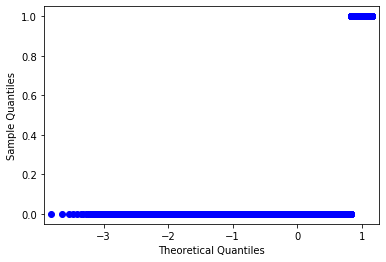

<IPython.core.display.Javascript object>

In [50]:
qqplot(top_songs["explicit"], line="s")
plt.show()

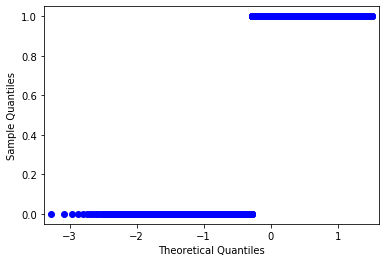

<IPython.core.display.Javascript object>

In [51]:
qqplot(rap_hiphop["explicit"], line="s")
plt.show()

## Kruskal Wallis - Popularity, Explicit vs Not Explicit

In [54]:
all_expl = top_songs[top_songs["explicit"] == 1]
all_not_expl = top_songs[top_songs["explicit"] == 0]

rap_hiphop_expl = rap_hiphop[rap_hiphop["explicit"] == 1]
rap_hiphop_not_expl = rap_hiphop[rap_hiphop["explicit"] == 0]

<IPython.core.display.Javascript object>

In [55]:
_, p = stats.kruskal(
    all_expl["week_pos"],
    all_not_expl["week_pos"],
    rap_hiphop_expl["week_pos"],
    rap_hiphop_not_expl["week_pos"],
)
p

8.232630168346857e-10

<IPython.core.display.Javascript object>

In [58]:
_, p1 = stats.mannwhitneyu(all_expl["week_pos"], all_not_expl["week_pos"])
_, p2 = stats.mannwhitneyu(all_expl["week_pos"], rap_hiphop_expl["week_pos"])
_, p3 = stats.mannwhitneyu(all_expl["week_pos"], rap_hiphop_not_expl["week_pos"])

_, p4 = stats.mannwhitneyu(all_not_expl["week_pos"], rap_hiphop_expl["week_pos"])
_, p5 = stats.mannwhitneyu(all_not_expl["week_pos"], rap_hiphop_not_expl["week_pos"])
_, p6 = stats.mannwhitneyu(rap_hiphop_expl["week_pos"], rap_hiphop_not_expl["week_pos"])


p_values = [p1, p2, p3, p4, p5, p6]
multipletests(p_values)

(array([ True, False,  True,  True,  True,  True]),
 array([1.52570874e-02, 4.13141653e-01, 8.85573548e-09, 1.52570874e-02,
        9.16038765e-08, 8.85573548e-09]),
 0.008512444610847103,
 0.008333333333333333)

<IPython.core.display.Javascript object>